In [ ]:

import os
import csv
import time
import copy
import json
import pickle
import random
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
import dnnlib
import numpy as np
import torch
from torch import autocast
from torch_utils import distributed as dist
from torch_utils import training_stats
from torch_utils import misc
from solver_utils import get_schedule
from models.ldm.util import instantiate_from_config
from torch_utils.download_util import check_file_by_key


def create_model(dataset_name=None, model_path=None, guidance_type=None, guidance_rate=None, device=None, is_second_stage=False, num_repeats=4):
    print("Function Parameters:")
    for key, value in locals().items():
        print(f"{key}: {value}")

    net_student = None
    if is_second_stage: # for second-stage distillation
        assert model_path is not None
        dist.print0(f'Loading the second-stage teacher model from "{model_path}"...')
        with dnnlib.util.open_url(model_path, verbose=(dist.get_rank() == 0)) as f:
            net = pickle.load(f)['model'].to(device)
        model_source = 'edm' if dataset_name in ['cifar10', 'ffhq', 'afhqv2', 'imagenet64'] else 'ldm'
        return net, model_source

    if model_path is None:
        model_path, _ = check_file_by_key(dataset_name)
    dist.print0(f'Loading the pre-trained diffusion model from "{model_path}"...')
    if dataset_name in ['cifar10', 'ffhq', 'afhqv2', 'imagenet64']:         # models from EDM
        with dnnlib.util.open_url(model_path, verbose=(dist.get_rank() == 0)) as f:
            net_temp = pickle.load(f)['ema'].to(device)
        network_kwargs = dnnlib.EasyDict()
        if dataset_name in ['cifar10']:
            network_kwargs.update(model_type='SongUNet', embedding_type='positional', encoder_type='standard', decoder_type='standard')
            network_kwargs.update(channel_mult_noise=1, resample_filter=[1,1], model_channels=128, channel_mult=[2,2,2])
            network_kwargs.update(dropout=0.13, use_fp16=False)
            network_kwargs.augment_dim = 9
            interface_kwargs = dict(img_resolution=32, img_channels=3, label_dim=0)
        elif dataset_name in ['ffhq', 'afhqv2']:
            network_kwargs.update(model_type='SongUNet', embedding_type='positional', encoder_type='standard', decoder_type='standard')
            network_kwargs.update(channel_mult_noise=1, resample_filter=[1,1], model_channels=128, channel_mult=[1,2,2,2])
            network_kwargs.update(dropout=0.05, use_fp16=False)
            network_kwargs.augment_dim = 9
            interface_kwargs = dict(img_resolution=64, img_channels=3, label_dim=0)
        else:
            network_kwargs.update(model_type='DhariwalUNet', model_channels=192, channel_mult=[1,2,3,4])
            interface_kwargs = dict(img_resolution=64, img_channels=3, label_dim=1000)
            
        network_kwargs.class_name = 'models.networks_edm.EDMPrecond'
        net = dnnlib.util.construct_class_by_name(**network_kwargs, **interface_kwargs) # subclass of torch.nn.Module
        net.to(device)
        net.load_state_dict(net_temp.state_dict(), strict=False)
        key_names = list(net.model.state_dict().keys())

        # Save to a text file
        with open("model_keys.txt", "w") as f:
            for key in key_names:
                f.write(key + "\n")
        network_kwargs.update(repeat=num_repeats)
        net_student = dnnlib.util.construct_class_by_name(**network_kwargs, **interface_kwargs)
        net_student.to(device)
        net_student.load_state_dict(net_temp.state_dict(), strict=False)

        del net_temp

        net.sigma_min = 0.006
        net.sigma_max = 80.0
        net_student.sigma_min = 0.006
        net_student.sigma_max = 80.0
        model_source = 'edm'
    elif dataset_name in ['lsun_bedroom_ldm', 'ffhq_ldm', 'ms_coco']:   # models from LDM
        from omegaconf import OmegaConf
        from models.networks_edm import CFGPrecond
        if dataset_name in ['lsun_bedroom_ldm']:
            assert guidance_type == 'uncond'
            config = OmegaConf.load('./models/ldm/configs/latent-diffusion/lsun_bedrooms-ldm-vq-4.yaml')
            net = load_ldm_model(config, model_path)
            net = CFGPrecond(net, img_resolution=64, img_channels=3, guidance_rate=1., guidance_type='uncond', label_dim=0).to(device)
            net.sigma_min = 0.006
        elif dataset_name in ['ffhq_ldm']:
            assert guidance_type == 'uncond'
            config = OmegaConf.load('./models/ldm/configs/latent-diffusion/ffhq-ldm-vq-4.yaml')
            net = load_ldm_model(config, model_path)
            net = CFGPrecond(net, img_resolution=64, img_channels=3, guidance_rate=1., guidance_type='uncond', label_dim=0).to(device)
            net.sigma_min = 0.006
        elif dataset_name in ['ms_coco']:
            assert guidance_type == 'cfg'
            config = OmegaConf.load('./models/ldm/configs/stable-diffusion/v1-inference.yaml')
            net = load_ldm_model(config, model_path)
            net = CFGPrecond(net, img_resolution=64, img_channels=4, guidance_rate=guidance_rate, guidance_type='classifier-free', label_dim=True).to(device)
            net.sigma_min = 0.1
        model_source = 'ldm'
    else:
        raise ValueError(f"Unsupported dataset_name: {dataset_name}")
    
    return net, net_student, model_source



net_copy, net, model_source = create_model("cifar10", None, None, 0.0, "cpu", False)


Function Parameters:
dataset_name: cifar10
model_path: None
guidance_type: None
guidance_rate: 0.0
device: cpu
is_second_stage: False
num_repeats: 4
Model already exists: ../training/src/cifar10/edm-cifar10-32x32-uncond-vp.pkl
Loading the pre-trained diffusion model from "../training/src/cifar10/edm-cifar10-32x32-uncond-vp.pkl"...
model.dec.32x32_aux_conv LASTLASYER
calling tilingg
calling tilingg


In [19]:
net_copy.eval(),net.eval()

(EDMPrecond(
   (model): SongUNet(
     (map_noise): PositionalEmbedding()
     (map_augment): Linear()
     (map_layer0): Linear()
     (map_layer1): Linear()
     (map_step): PositionalEmbedding()
     (map_step_layer0): Linear()
     (map_step_layer1): Linear()
     (enc): ModuleDict(
       (32x32_conv): Conv2d()
       (32x32_block0): UNetBlock(
         (norm0): GroupNorm()
         (conv0): Conv2d()
         (affine): Linear()
         (norm1): GroupNorm()
         (conv1): Conv2d()
         (affine_step): Linear()
         (skip): Conv2d()
       )
       (32x32_block1): UNetBlock(
         (norm0): GroupNorm()
         (conv0): Conv2d()
         (affine): Linear()
         (norm1): GroupNorm()
         (conv1): Conv2d()
         (affine_step): Linear()
       )
       (32x32_block2): UNetBlock(
         (norm0): GroupNorm()
         (conv0): Conv2d()
         (affine): Linear()
         (norm1): GroupNorm()
         (conv1): Conv2d()
         (affine_step): Linear()
       )
 

In [20]:
import torch
def get_denoised(net, x, t, class_labels=None, condition=None, unconditional_condition=None, step_condition=None):
    if hasattr(net, 'guidance_type'):       # models from LDM and Stable Diffusion
        denoised = net(x, t, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition, step_condition=step_condition)
    elif hasattr(net, 'module') and hasattr(net.module, 'guidance_type'):       # for training: models from LDM and Stable Diffusion
        denoised = net(x, t, class_labels=class_labels, condition=condition, unconditional_condition=unconditional_condition, step_condition=step_condition)
    else:
        print("calling")
        denoised = net(x, t, class_labels=class_labels, step_condition=step_condition)
    return denoised

# Model config
img_resolution = 32
img_channels = 3
label_dim = 10


# Dummy input
B = 2
x = torch.randn(B, img_channels, img_resolution, img_resolution)
sigma = torch.full((B,), 1.0)  # constant noise level
class_labels = torch.zeros(B, label_dim)  # zero dummy labels
# step_condition = torch.full((B,), 7.0)    # constant step for conditioning
step_condition = None


In [21]:
# Run dummy forward
out_stu_1 = get_denoised(net, x, sigma, class_labels=class_labels, step_condition=step_condition)

print("Output shape:", out_stu_1.shape)
# Run dummy forward
out_teacher_1 = get_denoised(net_copy, x, sigma, class_labels=class_labels, step_condition=step_condition)
out_teacher_2 = get_denoised(net_copy, x, sigma, class_labels=class_labels, step_condition=step_condition)
out_teacher_3 = get_denoised(net_copy, x, sigma, class_labels=class_labels, step_condition=step_condition)

print("Output shape:", out_teacher_1.shape)

calling


Output shape: torch.Size([2, 12, 32, 32])
calling
calling
calling
Output shape: torch.Size([2, 3, 32, 32])


In [22]:
(out_teacher_1-out_teacher_2).abs().mean()

tensor(0., grad_fn=<MeanBackward0>)

In [23]:
print((out_stu_1[:,0:3] - out_teacher_1).mean())
print((out_stu_1[:,3:6] - out_teacher_1).mean())
print((out_stu_1[:,6:9] - out_teacher_1).mean())
print((out_stu_1[:,9:12] - out_teacher_1).mean())

tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)
tensor(0., grad_fn=<MeanBackward0>)


In [15]:
model = net.model
model_orig = net_copy.model


# Get last layer prefix (e.g., 'dec.32x32_aux_conv')
last_layer_prefix = model.last_layer.replace('model.', '')

# Collect weights and biases
for name, param in model.named_parameters():
    if name.startswith(last_layer_prefix):
        orig = dict(model_orig.named_parameters())[name]
        tiled = param
        print(f"\nAssigned:\n  orig -> {name} ({orig.shape})\n  tiled -> {name} ({tiled.shape})")
        # break



Assigned:
  orig -> dec.32x32_aux_conv.weight (torch.Size([3, 256, 3, 3]))
  tiled -> dec.32x32_aux_conv.weight (torch.Size([3, 256, 3, 3]))

Assigned:
  orig -> dec.32x32_aux_conv.bias (torch.Size([3]))
  tiled -> dec.32x32_aux_conv.bias (torch.Size([3]))


In [5]:
(tiled[0:3]-orig).mean()

tensor(0., grad_fn=<MeanBackward0>)

In [ ]:
import torch
a = torch.rand(3,256,32,32)
b = a.repeat(4,1,1,1)
b.shape

In [ ]:
(b[4:7]-a).mean()

In [ ]:
print(b.shape)         # torch.Size([12, 256, 32, 32])
print((b[0] == a).all())  # Should be True


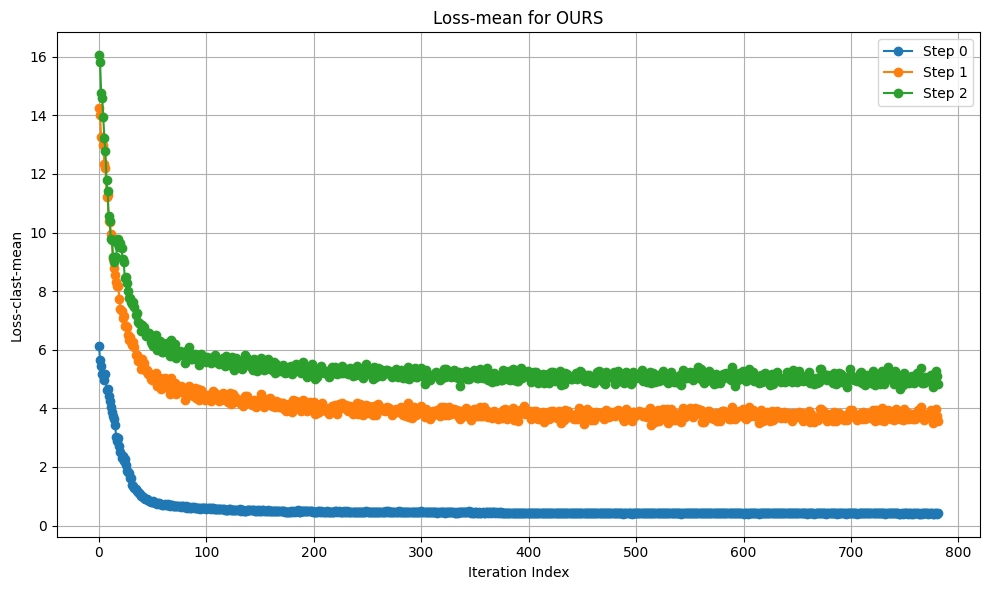

In [5]:
import re
import matplotlib.pyplot as plt

# Load log file
with open(r'/teamspace/studios/this_studio/sfd-main/exps/00000-cifar10-4-3-dpmpp-3-poly7.0/log.txt', 'r') as file:
    log_lines = file.readlines()

# Dictionaries to store loss values per step
loss_by_step = {
    0: [],
    1: [],
    2: []
}

# Extract losses for each step
for line in log_lines:
    match = re.search(r"Step: (\d) \| Loss-clast-mean:\s+([0-9.]+)", line)
    if match:
        step = int(match.group(1))
        loss = float(match.group(2))
        loss_by_step[step].append(loss)

# Plotting
plt.figure(figsize=(10, 6))
for step in sorted(loss_by_step.keys()):
    plt.plot(loss_by_step[step], label=f'Step {step}', marker='o')

plt.title('Loss-mean for OURS weight ')
plt.xlabel('Iteration Index')
plt.ylabel('Loss-clast-mean')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np

def compare_training_logs(original_log_path, our_log_path, branch=1):
    def extract_losses(file_path, loss_type):
        all_losses = []
        with open(file_path, 'r') as f:
            content = f.read()
            for step in range(3):
                if loss_type == 'original':
                    pattern = re.compile(rf"Step:\s*{step}\s*\|\s*Loss-mean:\s*([0-9]+\.[0-9]+)")
                else:
                    pattern = re.compile(rf"Step:\s*{step}\s*\|\s*Loss_ls-{branch}-mean:\s*([0-9]+\.[0-9]+)")
                matches = re.findall(pattern, content)
                all_losses.append([float(m) for m in matches])
        return all_losses

    def calculate_oscillation(losses):
        if len(losses) < 2:
            return {'variance': 0, 'std': 0, 'range': 0, 'mean': 0}
        losses_array = np.array(losses)
        return {
            'variance': np.var(losses_array),
            'std': np.std(losses_array),
            'range': np.max(losses_array) - np.min(losses_array),
            'mean': np.mean(losses_array)
        }

    original_all = extract_losses(original_log_path, 'original')
    our_all = extract_losses(our_log_path, 'ours')
    print("="*150)
    print("For branch  ",branch, " Training")
    print("="*150)
    for step in range(3):
        original_losses = original_all[step]
        our_losses = our_all[step]

        original_metrics = calculate_oscillation(original_losses)
        our_metrics = calculate_oscillation(our_losses)

        # plt.figure(figsize=(12, 6))

        # plt.subplot(1, 2, 1)
        # plt.plot(original_losses, 'b-o', label='Original Method', alpha=0.7)
        # plt.title(f'Original Method - Loss Oscillation (Step {step})')
        # plt.xlabel('Iteration')
        # plt.ylabel('Loss')
        # plt.grid(True, alpha=0.3)
        # plt.legend()

        # plt.subplot(1, 2, 2)
        # plt.plot(our_losses, 'r-o', label='Our Method', alpha=0.7)
        # plt.title(f'Our Method - Loss Oscillation (Step {step})')
        # plt.xlabel('Iteration')
        # plt.ylabel('Loss')
        # plt.grid(True, alpha=0.3)
        # plt.legend()

        # plt.tight_layout()
        # plt.show()

        print("="*60)
        print(f"STEP {step} - TRAINING LOSS OSCILLATION COMPARISON")
        print("="*60)

        print(f"\nOur Method:")
        # print(f"  Mean Loss: {our_metrics['mean']:.4f}")
        # print(f"  Std Dev:   {our_metrics['std']:.4f}")
        # print(f"  Variance:  {our_metrics['variance']:.4f}")
        # print(f"  Range:     {our_metrics['range']:.4f}")
        print(f"  Total Steps: {len(our_losses)}")
        print(f"  Last loss step {step} branch {branch}:  {our_losses[-1] if our_losses else 'N/A'}")
        print(f"  Last loss of original step {step}:  {original_losses[-1] if original_losses else 'N/A'}")

    return {
        'original_losses': original_all,
        'our_losses': our_all,
    }

# teacher 0 [1 2 3] 4 [5 6 7] 8 [9 10 11] 12
# 0 [1 2 3 4] 5 6 7 


In [2]:
results = compare_training_logs('original_training_logs.txt', r'/teamspace/studios/this_studio/sfd-main/exps/00134-cifar10-4-3-dpmpp-3-poly7.0/log.txt',branch=1)
results = compare_training_logs('original_training_logs.txt', r'/teamspace/studios/this_studio/sfd-main/exps/00134-cifar10-4-3-dpmpp-3-poly7.0/log.txt',branch=2)
results = compare_training_logs('original_training_logs.txt', r'/teamspace/studios/this_studio/sfd-main/exps/00134-cifar10-4-3-dpmpp-3-poly7.0/log.txt',branch=3)
results = compare_training_logs('original_training_logs.txt', r'/teamspace/studios/this_studio/sfd-main/exps/00134-cifar10-4-3-dpmpp-3-poly7.0/log.txt',branch=0)


For branch   1  Training
STEP 0 - TRAINING LOSS OSCILLATION COMPARISON

Our Method:
  Total Steps: 782
  Last loss step 0 branch 1:  0.30109838
  Last loss of original step 0:  0.38475537
STEP 1 - TRAINING LOSS OSCILLATION COMPARISON

Our Method:
  Total Steps: 782
  Last loss step 1 branch 1:  1.151793
  Last loss of original step 1:  3.48407173
STEP 2 - TRAINING LOSS OSCILLATION COMPARISON

Our Method:
  Total Steps: 782
  Last loss step 2 branch 1:  4.65574169
  Last loss of original step 2:  4.85880232
For branch   2  Training
STEP 0 - TRAINING LOSS OSCILLATION COMPARISON

Our Method:
  Total Steps: 782
  Last loss step 0 branch 2:  0.31655908
  Last loss of original step 0:  0.38475537
STEP 1 - TRAINING LOSS OSCILLATION COMPARISON

Our Method:
  Total Steps: 782
  Last loss step 1 branch 2:  1.92400157
  Last loss of original step 1:  3.48407173
STEP 2 - TRAINING LOSS OSCILLATION COMPARISON

Our Method:
  Total Steps: 782
  Last loss step 2 branch 2:  4.91851616
  Last loss of ori

In [2]:
import re

def find_min_s2_loss(log_path: str) -> float:

    """
    Parse the log file to extract the last loss values for steps 0, 1, 2
    and return their sum.
    """

    all_losses = [[] for _ in range(3)]

    pattern = re.compile(r"Step:\s*(\d+)\s*\|\s*Loss-mean:\s*([0-9]+\.[0-9]+)")

    with open(log_path, 'r') as f:
        for line in f:
            m = pattern.search(line)
            if m:
                step = int(m.group(1))
                loss = float(m.group(2))
                if 0 <= step < 3:
                    all_losses[step].append(loss)

    step_2_losses=all_losses[-1]

    # print(min(step_2_loss[-400:]))

    return min(step_2_losses)


x=find_min_s2_loss("/teamspace/studios/this_studio/sfd-main/exps/00155-cifar10-4-2-dpmpp-3-poly7.0-afs/log.txt")
print(x)

4.22973728


In [4]:
import re

def find_last_tick(log_path: str) -> int:
    """
    Parse the log file to find the tick value from the last 'tick' line.
    """
    tick_pattern = re.compile(r"tick\s+(\d+)\b")
    last_tick = None

    with open(log_path, 'r') as f:
        for line in f:
            match = tick_pattern.search(line)
            if match:
                last_tick = int(match.group(1))

    return last_tick

# Example usage
log_file = "/teamspace/studios/this_studio/sfd-main/exps/00155-cifar10-4-2-dpmpp-3-poly7.0-afs/log.txt"
print(find_last_tick(log_file))


196


In [7]:
import re

def find_min_s2_loss_ls3(log_path: str) -> float:
    """
    Parse the log file to extract all Step 2 Loss_ls-3-mean values
    and return their minimum.
    """
    
    step2_ls3_losses = []
    
    # Pattern to match Step 2 Loss_ls-3-mean lines
    step2_ls3_pattern = re.compile(r"Step:\s*2\s*\|\s*Loss_ls-3-mean:\s*([0-9]+\.[0-9]+)")
    
    with open(log_path, 'r') as f:
        for line in f:
            match = step2_ls3_pattern.search(line)
            if match:
                loss_value = float(match.group(1))
                step2_ls3_losses.append(loss_value)
                # print(f"Found Step 2 Loss_ls-3-mean: {loss_value}")
    
    if not step2_ls3_losses:
        raise ValueError("No Step 2 Loss_ls-3-mean values found")
    
    min_loss = min(step2_ls3_losses)
    # print(f"\nAll Step 2 Loss_ls-3-mean values: {step2_ls3_losses}")
    # print(f"Total count: {len(step2_ls3_losses)}")
    # print(f"Minimum Step 2 Loss_ls-3-mean: {min_loss}")
    
    return min_loss

# Test with your log file
# x = find_min_s2_loss_ls3("/teamspace/studios/this_studio/sfd-main/training/original_training_logs.txt")
# print(f"Result: {x}")

# Test with your log file
x = find_min_s2_loss_ls3("/teamspace/studios/this_studio/sfd-main/exps/00148-cifar10-4-3-dpmpp-3-poly7.0/log.txt")
print(f"Result: {x}")


Result: 1.93928492


In [56]:
import re

def sum_last_losses(log_path):
    def extract_losses(file_path):
        all_losses = []
        with open(file_path, 'r') as f:
            content = f.read()
            for step in range(3):
                pattern = re.compile(rf"Step:\s*{step}\s*\|\s*Loss-mean:\s*([0-9]+\.[0-9]+)")
                matches = re.findall(pattern, content)
                losses = [float(m) for m in matches]
                all_losses.append(losses)
        return all_losses

    all_losses = extract_losses(log_path)
    last_losses = [step_losses[-1] if step_losses else 0 for step_losses in all_losses]
    total_sum = sum(last_losses)

    print("Last losses for steps 0, 1, 2:", last_losses)
    print("Sum of last losses:", total_sum)
    return total_sum


sum_last_losses(r'/teamspace/studios/this_studio/sfd-main/exps/00134-cifar10-4-3-dpmpp-3-poly7.0/log.txt')

Last losses for steps 0, 1, 2: [1.41737235, 7.81435966, 18.53651047]
Sum of last losses: 27.768242479999998


27.768242479999998